In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"boadisamson","key":"2a97253b56bb6ed3d288e95d54964800"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

 99% 1.14G/1.15G [00:11<00:00, 80.8MB/s]
100% 1.15G/1.15G [00:11<00:00, 103MB/s] 
Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          
Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/tes

In [0]:
!rm -rf chest-xray-pneumonia.zip
!rm -rf chest_xray.zip
!rm -rf __MACOSX
!rm -rf kaggle.json

## Prepare and preprocess data

In [0]:
train_dir = 'chest_xray/train/'
validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/'

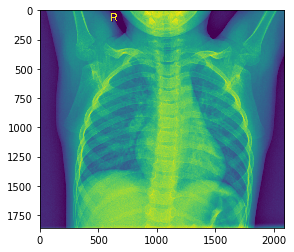

In [6]:
img = mpimg.imread(train_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

Visualize other images

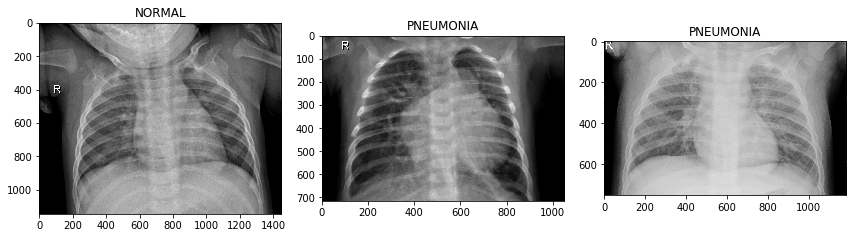

In [7]:
img_normal = plt.imread(f'{train_dir}NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread(f'{train_dir}PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread(f'{train_dir}PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

## Build the model using InceptionV3 as pre-trained model


In [8]:
K.clear_session()

NUM_CLASSES = 2


def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

model = create_model((150, 150, 3))

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 8s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [9]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(2048, 512) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(512, 256) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 128) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(128, 2) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(2,) dtype=float32>]

Compile the model selecting the optimizer, the loss function, and the metric.

In [0]:
# with strategy.scope():
optimizer = Adam(lr=0.0001)
# optimizer = RMSprop()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

## Data augmentation

In [11]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = 'categorical'


def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


## Train the model

In [13]:
# with strategy.scope():
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=100,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

MODEL_FILE = 'pneumonia_v0.0.1.hd5'
model.save(MODEL_FILE)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
32/32 [==============================] - 77s 2s/step - loss: 0.5844 - acc: 0.7201 - val_loss: 0.6604 - val_acc: 0.5000
Epoch 2/100
32/32 [==============================] - 49s 2s/step - loss: 0.4386 - acc: 0.8012 - val_loss: 0.7931 - val_acc: 0.6250
Epoch 3/100
32/32 [==============================] - 58s 2s/step - loss: 0.3334 - acc: 0.8614 - val_loss: 1.6305 - val_acc: 0.6250
Epoch 4/100
32/32 [==============================] - 58s 2s/step - loss: 0.2881 - acc: 0.8804 - val_loss: 1.1956 - val_acc: 0.6250
Epoch 5/100
32/32 [==============================] - 56s 2s/step - loss: 0.2692 - acc: 0.8953 - val_loss: 1.2785 - val_acc: 0.6250
Epoch 6/100
32/32 [==============================] - 57s 2s/step - loss: 0.2493 - acc: 0.8967 - val_loss: 1.0899 - val_acc: 0.6250
Epoch 7/100
32/32 [==============================] - 56s 2s/step - loss: 0.2465 - acc: 0.9026 - val_loss: 0.9415 - val_a

In [30]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
#drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
%mkdir -p '/content/drive/My Drive/ML_Course_Siraj/Week_04'
!mv {MODEL_FILE} '/content/drive/My Drive/ML_Course_Siraj/Week_04'

mv: cannot stat '/content/drive/My': No such file or directory
mv: cannot stat 'Drive/ML_Course_Siraj/Week_04/pneumonia_v0.0.1.hd5': No such file or directory


## Model performance visualization over the epochs

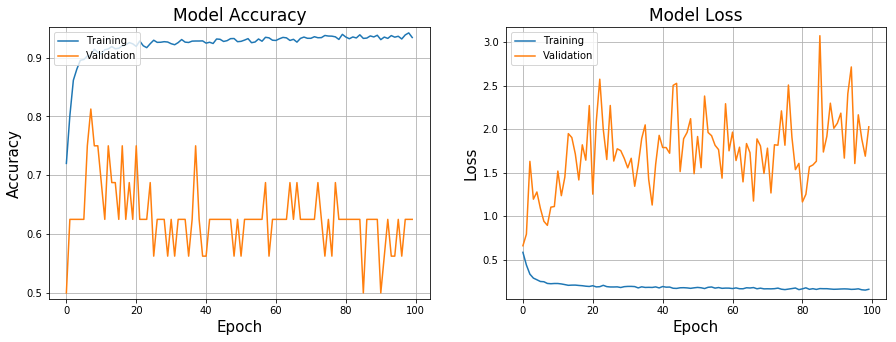

In [31]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

## Evaluate model

In [0]:
MODEL_FILE = f'/content/drive/My Drive/ML_Course_Siraj/Week_04/pneumonia_v0.0.1.hd5'
model = tf.keras.models.load_model(MODEL_FILE)

In [34]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 7s 7s/step - loss: 1.3522 - acc: 0.7003
Loss     : 1.35  
Accuracy : 70.03%


In [35]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

1/1 [==============================] - 8s 8s/step


In [36]:
import random

num_of_batch = len(test_generator)
batch_no = random.randint(0, num_of_batch - 1)

y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 70.03%
-----------------------------------


## Make predictions

In [43]:
desired_batch_size=7

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=desired_batch_size)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/desired_batch_size))

Found 624 images belonging to 2 classes.


In [44]:
import pandas as pd

predicted_class_indices = np.argmax(predict, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

results

,Filename,Predictions
0,NORMAL/IM-0001-0001.jpeg,PNEUMONIA
1,NORMAL/IM-0003-0001.jpeg,PNEUMONIA
2,NORMAL/IM-0005-0001.jpeg,PNEUMONIA
3,NORMAL/IM-0006-0001.jpeg,NORMAL
4,NORMAL/IM-0007-0001.jpeg,NORMAL
5,NORMAL/IM-0009-0001.jpeg,NORMAL
6,NORMAL/IM-0010-0001.jpeg,NORMAL
7,NORMAL/IM-0011-0001-0001.jpeg,PNEUMONIA
8,NORMAL/IM-0011-0001-0002.jpeg,PNEUMONIA
9,NORMAL/IM-0011-0001.jpeg,NORMAL
